**Project title:** Sectoral - Auto and transport

**Group#:** 27

## Overview
This project analyses holdings across several transportation & auto-focused mutual funds.

## How to run
1. Create and activate a virtual environment:

```powershell
python -m venv .venv; .venv\Scripts\Activate.ps1
```

2. Install dependencies:

```powershell
python -m pip install --upgrade pip
pip install -r requirements.txt
```

3. Open and run the notebook `Group27_Code.ipynb` in Jupyter:

```powershell
jupyter notebook
# then open the file and run cells (Kernel -> Restart & Run All)
```

## Environment and dependencies
- Fixed seed for reproducibility: `SEED = 42`. In Python cells set seeds with:

```python
import random
import numpy as np
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
```

- Example `requirements.txt` (pinned versions):

```
pandas==1.5.2
numpy==1.23.5
matplotlib==3.6.2
jupyter==1.0.0
```

Notes:
- Use relative paths (the notebook expects `Holdings_Data/` next to this notebook).
- If data files exceed repository size limits, host them externally and load via raw URL.

## Contact
For questions about reproducibility or data access:

> Aalok Thakkar - 202301429@dau.ac.in


## Holdings Analysis
This notebook loads all CSVs in `Holdings_Data/`, standardises the columns, computes the requested features (Consensus Score, Conviction Metric, Normalized Holding %, Momentum Flag), then performs the commonality, concentration and momentum analyses requested by the project brief.

### Import and list files

- Purpose: import required libraries and list all CSV files in `Holdings_Data/`.
- Output: `files` will contain the CSV paths found; run to confirm available holdings files.

In [35]:
# Import libraries
import pandas as pd
import numpy as np
from pathlib import Path
import re

BASE = Path('Holdings_Data')
files = list(BASE.glob('*.csv'))
files

[WindowsPath('Holdings_Data/Aditya_Birla_Sun_Life_Transportation_And_Logistics_Fund.csv'),
 WindowsPath('Holdings_Data/Bandhan_Transportaion_And_Logistics_Fund.csv'),
 WindowsPath('Holdings_Data/Kotak_Transportation_Logistics_Fund.csv'),
 WindowsPath('Holdings_Data/stock_holdings_HDFC.csv'),
 WindowsPath('Holdings_Data/stock_holdings_ICICI_Prudential.csv'),
 WindowsPath('Holdings_Data/UTI_Transportation_Logistics_fund.csv')]

### Parsing helpers

- Purpose: convert percent and quantity strings to numeric values for later computation.
- Functions:
  - `parse_pct`: extracts a leading percent number from strings like `10.82% (Sep 2025)` and returns a float (e.g., `10.82`).
  - `parse_qty`: converts quantity strings like `1.12 L` or `30.00 k` to numeric counts (`L` -> 100,000; `k` -> 1,000).
- Output: numeric `_num` columns will be created in the loader cell.

In [36]:
# Helper parsers
def parse_pct(x):
    if pd.isna(x):
        return np.nan
    s = str(x).strip()
    # extract leading percent value
    m = re.search(r'(-?\d+\.?\d*)%?', s)
    if not m:
        return np.nan
    try:
        return float(m.group(1))
    except Exception:
        return np.nan

def parse_qty(s):
    if pd.isna(s):
        return np.nan
    s = str(s).strip()
    # parse quantities like '1.12 L' or '30.00 k'
    s = s.replace(',', '')
    m = re.match(r'([\d\.]+)\s*([kKlL]?)', s)
    if not m:
        try:
            return float(s)
        except Exception:
            return np.nan
    val = float(m.group(1))
    suf = m.group(2).lower()
    if suf == 'k':
        val *= 1_000
    elif suf == 'l':
        val *= 100_000
    return val

### Load & standardize files

- Purpose: read each CSV, normalize column names, add a `fund` column, and parse numeric fields into `_num` columns.
- Actions performed:
  - Renames columns to a consistent schema.
  - Parses percent/quantity columns using the helper functions.
  - Concatenates all fund DataFrames into `combined`.
- Output: `combined` DataFrame (use `combined.head()` to preview).

In [37]:
# Load and standardize all holdings files into one DataFrame
dfs = []
for fp in files:
    fund_name = fp.stem
    df = pd.read_csv(fp)
    df.columns = [c.strip() for c in df.columns]
    # rename columns to consistent names
    col_map = {
        'Stock Invested in': 'Stock',
        'Stock Invested In': 'Stock',
        '% of Total Holdings': 'pct_of_total',
        'Value (Mn)': 'value_mn',
        'Value(Mn)': 'value_mn',
        '1M Change': '1m_change',
        '1Y Highest Holding': '1y_high',
        '1Y Lowest Holding': '1y_low',
        'Quantity': 'quantity',
        '1M Change in Qty': '1m_change_qty',
        'Sector': 'sector'
    }
    df = df.rename(columns=col_map)
    df['fund'] = fund_name
    # parse numeric columns (use .get to avoid KeyError if a column wasn't present after renaming)
    df['pct_of_total_num'] = df.get('pct_of_total').apply(parse_pct) if 'pct_of_total' in df.columns else np.nan
    df['1m_change_num'] = df.get('1m_change').apply(parse_pct) if '1m_change' in df.columns else np.nan
    df['1y_high_num'] = df.get('1y_high').apply(parse_pct) if '1y_high' in df.columns else np.nan
    df['1y_low_num'] = df.get('1y_low').apply(parse_pct) if '1y_low' in df.columns else np.nan
    df['value_mn_num'] = pd.to_numeric(df.get('value_mn', np.nan), errors='coerce')
    df['quantity_num'] = df.get('quantity').apply(parse_qty) if 'quantity' in df.columns else np.nan
    df['1m_change_qty_num'] = pd.to_numeric(df.get('1m_change_qty', 0), errors='coerce')
    dfs.append(df)

combined = pd.concat(dfs, ignore_index=True, sort=False)
combined.shape

combined.sample(10)

,Stock,sector,value_mn,pct_of_total,1m_change,1y_high,1y_low,quantity,1m_change_qty,fund,pct_of_total_num,1m_change_num,1y_high_num,1y_low_num,value_mn_num,quantity_num,1m_change_qty_num,Quantity (L),1M Change in Qty (L)
0,Mahindra & Mahindra Ltd.,Passenger cars & utility vehicles,1790.8,11.26%,0.21%,11.26%,10.19%,5.14 L,0.0,Aditya_Birla_Sun_Life_Transportation_And_Logis...,11.26,0.21,11.26,10.19,1790.8,514000.0,0.0,NaN,NaN
5,Hero Motocorp Ltd.,2/3 wheelers,803.0,5.05%,0.07%,5.46%,4.01%,1.45 L,0.0,Aditya_Birla_Sun_Life_Transportation_And_Logis...,5.05,0.07,5.46,4.01,803.0,145000.0,0.0,NaN,NaN
36,Bajaj Auto Ltd.,2/3 wheelers,907.0,5.23%,-0.13%,7.06% (Jan 2025),5.23% (Oct 2025),1.02 L,0.0,stock_holdings_HDFC,5.23,-0.13,7.06,5.23,907.0,102000.0,0.0,NaN,NaN
45,Tata Motors Passenger Vehicles Ltd.,Passenger cars & utility vehicles,1458.9,4.83%,-3.20%,8.82% (Mar 2025),4.83% (Oct 2025),NaN,NaN,stock_holdings_ICICI_Prudential,4.83,-3.20,8.82,4.83,1458.9,NaN,0.0,35.58,0.0
13,Bosch Ltd.,Auto components & equipments,335.2,5.09%,-0.14%,6.35%,4.93%,9.00 k,0.00,Bandhan_Transportaion_And_Logistics_Fund,5.09,-0.14,6.35,4.93,335.2,9000.0,0.0,NaN,NaN
54,InterGlobe Aviation Ltd.,Airline,2013.4,5.02%,-0.45%,6.46% (Mar 2025),5.02% (Oct 2025),3.58 L,-0.30 L,UTI_Transportation_Logistics_fund,5.02,-0.45,6.46,5.02,2013.4,358000.0,NaN,NaN,NaN
33,Bosch Ltd.,Auto components & equipments,1117.4,6.45%,-0.48%,8.16% (Jul 2025),5.4% (Jan 2025),30.00 k,0.0,stock_holdings_HDFC,6.45,-0.48,8.16,5.40,1117.4,30000.0,0.0,NaN,NaN
48,Hyundai Motor India Ltd.,Passenger cars & utility vehicles,1005.8,3.33%,-1.06%,4.39% (Sep 2025),2.26% (Dec 2024),NaN,NaN,stock_holdings_ICICI_Prudential,3.33,-1.06,4.39,2.26,1005.8,NaN,0.0,4.12,-1.0
12,Mahindra & Mahindra Ltd.,Passenger cars & utility vehicles,435.9,6.62%,0.09%,12.57%,6.53%,1.25 L,0.00,Bandhan_Transportaion_And_Logistics_Fund,6.62,0.09,12.57,6.53,435.9,125000.0,0.0,NaN,NaN
57,Hyundai Motor India Ltd.,Passenger cars & utility vehicles,1734.8,4.33%,0.51%,4.33% (Oct 2025),1.89% (Jan 2025),7.11 L,1.25 L,UTI_Transportation_Logistics_fund,4.33,0.51,4.33,1.89,1734.8,711000.0,NaN,NaN,NaN


## Data Cleaning

### Missing Values Analysis

In [38]:
missing = combined.isna().sum().rename('missing_count').reset_index().rename(columns={'index':'column'})
missing['missing_pct'] = (missing['missing_count'] / len(combined) * 100).round(3)
from IPython.display import display
display(missing.sort_values('missing_pct', ascending=False))


,column,missing_count,missing_pct
18,1M Change in Qty (L),50,83.333
17,Quantity (L),50,83.333
16,1m_change_qty_num,10,16.667
15,quantity_num,10,16.667
7,quantity,10,16.667
8,1m_change_qty,10,16.667
11,1m_change_num,0,0.000
14,value_mn_num,0,0.000
13,1y_low_num,0,0.000
12,1y_high_num,0,0.000


### Imputation

In [39]:

# Imputation (stock median -> global median) for main numeric columns
num_cols = ['pct_of_total_num','1m_change_num','1y_high_num','1y_low_num','value_mn_num','quantity_num','1m_change_qty_num']
for col in num_cols:
    if col in combined.columns:
        flag_col = col + '_imputed'
        combined[flag_col] = False
        medians = combined.groupby('Stock')[col].transform('median')
        mask = combined[col].isna()
        combined.loc[mask, col] = medians[mask]
        mask2 = combined[col].isna()
        if mask2.any():
            global_med = combined[col].median()
            combined.loc[mask2, col] = global_med
            combined.loc[mask2, flag_col] = True
        filled_by_stock = mask & (~combined[col].isna())
        combined.loc[filled_by_stock, flag_col] = True


### Feature engineering

- Purpose: compute analysis-ready features for each holding.
- Features created:
  - `consensus_score`: number of funds holding the stock.
  - `conviction_metric`: normalized position vs 1Y range: (current - 1Y low) / (1Y high - 1Y low).
  - `peer_mean_pct` and `normalized_holding_pct`: peer average and fund's overweight/underweight vs peer mean.
  - `momentum_flag`: 'Buy' / 'Sell' / 'Neutral' using 1M Change thresholds (>0.1%, <-0.1%).
- Output: a preview of `combined` with the new columns.

In [40]:
consensus = combined[combined['pct_of_total_num'].notna()].groupby('Stock')['fund'].nunique().rename('consensus_score')
combined = combined.merge(consensus, on='Stock', how='left')

# Conviction Metric
def conviction(row):
    hi = row['1y_high_num']
    lo = row['1y_low_num']
    cur = row['pct_of_total_num']
    if pd.isna(cur) or pd.isna(hi) or pd.isna(lo):
        return np.nan
    denom = (hi - lo)
    if denom == 0:
        return np.nan
    return (cur - lo) / denom

combined['conviction_metric'] = combined.apply(conviction, axis=1)

# Normalized Holding % (over/underweight vs peer average)
peer_mean = combined.groupby('Stock')['pct_of_total_num'].mean().rename('peer_mean_pct')
combined = combined.merge(peer_mean, on='Stock', how='left')
combined['normalized_holding_pct'] = combined['pct_of_total_num'] - combined['peer_mean_pct']

# Momentum flag based on 1M Change threshold of 0.1%
def momentum_flag(x):
    if pd.isna(x):
        return 'Neutral'
    if x > 0.1:
        return 'Buy'
    if x < -0.1:
        return 'Sell'
    return 'Neutral'

combined['momentum_flag'] = combined['1m_change_num'].apply(momentum_flag)

combined[['Stock','fund','sector','pct_of_total_num','1y_high_num','1y_low_num','consensus_score','conviction_metric','normalized_holding_pct','1m_change_num','momentum_flag']].sample(10)

,Stock,fund,sector,pct_of_total_num,1y_high_num,1y_low_num,consensus_score,conviction_metric,normalized_holding_pct,1m_change_num,momentum_flag
18,InterGlobe Aviation Ltd.,Bandhan_Transportaion_And_Logistics_Fund,Airline,2.99,5.16,2.82,5,0.072650,-1.792000,0.01,Neutral
45,Tata Motors Passenger Vehicles Ltd.,stock_holdings_ICICI_Prudential,Passenger cars & utility vehicles,4.83,8.82,4.83,1,0.000000,0.000000,-3.20,Sell
47,Eicher Motors Ltd.,stock_holdings_ICICI_Prudential,2/3 wheelers,4.34,7.61,4.34,4,0.000000,-2.680000,-1.94,Sell
48,Hyundai Motor India Ltd.,stock_holdings_ICICI_Prudential,Passenger cars & utility vehicles,3.33,4.39,2.26,4,0.502347,-1.550000,-1.06,Sell
4,Motherson Sumi Systems Ltd.,Aditya_Birla_Sun_Life_Transportation_And_Logis...,Auto components & equipments,5.47,5.74,4.99,2,0.640000,1.215000,-0.01,Neutral
40,Mahindra & Mahindra Ltd.,stock_holdings_ICICI_Prudential,Passenger cars & utility vehicles,13.69,15.24,11.91,6,0.534535,4.270000,-0.29,Sell
27,InterGlobe Aviation Ltd.,Kotak_Transportation_Logistics_Fund,Airline,4.68,7.82,0.00,5,0.598465,-0.102000,-0.31,Sell
29,Great Eastern Shipping Co. Ltd.,Kotak_Transportation_Logistics_Fund,Shipping,3.30,3.30,0.00,1,1.000000,0.000000,0.11,Buy
31,Eicher Motors Ltd.,stock_holdings_HDFC,2/3 wheelers,9.26,10.50,8.64,4,0.333333,2.240000,-0.46,Sell
55,Bajaj Auto Ltd.,UTI_Transportation_Logistics_fund,2/3 wheelers,4.71,6.23,4.65,6,0.037975,0.263333,0.06,Neutral


### Commonality: top common stocks

- Purpose: count how many funds hold each stock to find commonly held names.
- Output:
  - `stock_counts`: number of funds per stock, sorted descending.
  - `top_common`: stocks held by the maximum number of funds.

In [41]:
stock_counts = combined.groupby('Stock')['fund'].nunique().rename('fund_count').reset_index()
stock_counts = stock_counts.sort_values('fund_count', ascending=False)
top_common = stock_counts[stock_counts['fund_count'] >= stock_counts['fund_count'].max()]
top_common.head()

,Stock,fund_count
2,Bajaj Auto Ltd.,6
13,Maruti Suzuki India Ltd.,6
12,Mahindra & Mahindra Ltd.,6


### Aggregate holding % across funds

- Purpose: sum `% of Total Holdings` for each stock across all funds to find collectively large exposures.
- Output: `agg_pct` lists stocks by combined percent exposure across funds.

In [42]:
# Aggregate Holding % across funds (sum of pct_of_total)
agg_pct = combined.groupby('Stock')['pct_of_total_num'].sum().rename('agg_pct_sum').reset_index().sort_values('agg_pct_sum', ascending=False)
agg_pct.head()

,Stock,agg_pct_sum
13,Maruti Suzuki India Ltd.,58.47
12,Mahindra & Mahindra Ltd.,56.52
5,Eternal Ltd.,32.51
8,Hero Motocorp Ltd.,31.27
4,Eicher Motors Ltd.,28.08


### Sector concentration (Count)

- Purpose: for each fund, take the top-5 holdings and count how often each sector appears across all funds' top-5 lists.
- Output: `sector_count` shows the frequency each sector appears in top-5 holdings.

In [43]:
top5_each = combined.sort_values(['fund','pct_of_total_num'], ascending=[True, False]).groupby('fund').head(5)
sector_count = top5_each['sector'].value_counts().rename_axis('sector').reset_index(name='count')
sector_count

,sector,count
0,Passenger cars & utility vehicles,13
1,E-retail/ e-commerce,5
2,2/3 wheelers,5
3,Auto components & equipments,4
4,Airline,3


### Sector concentration (Value)

- Purpose: sum `Value (Mn)` by sector across all funds to find which sectors hold the greatest total value.
- Output: `sector_value` lists sectors sorted by total value across funds.

In [44]:
# Sector concentration (Value): sum value_mn_num by sector across all funds
sector_value = combined.groupby('sector')['value_mn_num'].sum().rename('total_value_mn').reset_index().sort_values('total_value_mn', ascending=False)
sector_value.head()

,sector,total_value_mn
5,Passenger cars & utility vehicles,29888.4
0,2/3 wheelers,21669.9
4,E-retail/ e-commerce,7377.8
1,Airline,4992.6
2,Auto components & equipments,4322.2


### Momentum & Sentiment Analysis

- Purpose: identify strong positive and negative momentum moves and holdings near their 1Y highs.
- Outputs:
  - `pos_mom`: holdings with positive 1M Change (and positive qty change when available), sorted descending.
  - `neg_mom`: holdings with negative 1M Change (and negative qty change when available), sorted ascending.
  - `near_highs`: holdings where current `% of Total Holdings` is within 0.1% of the 1Y high.

In [45]:
# 3. Momentum & Sentiment Analysis
# Strong Positive Momentum: large positive 1M Change and positive qty change
pos_mom = combined[(combined['1m_change_num'] > 0)].copy()
pos_mom = pos_mom[pos_mom['1m_change_qty_num'] > 0] if '1m_change_qty_num' in pos_mom.columns else pos_mom
pos_mom = pos_mom.sort_values('1m_change_num', ascending=False)
pos_mom[['Stock','fund','1m_change_num','1m_change_qty_num','quantity_num']].head()

# Strong Negative Momentum: large negative 1M Change and negative qty change
neg_mom = combined[(combined['1m_change_num'] < 0)].copy()
neg_mom = neg_mom[neg_mom['1m_change_qty_num'] < 0] if '1m_change_qty_num' in neg_mom.columns else neg_mom
neg_mom = neg_mom.sort_values('1m_change_num')
neg_mom[['Stock','fund','1m_change_num','1m_change_qty_num','quantity_num']].head()

# Near 1Y Highs: where current pct within 0.1% of 1Y high
near_highs = combined[combined['pct_of_total_num'].notna() & combined['1y_high_num'].notna()].copy()
near_highs = near_highs[ (near_highs['1y_high_num'] - near_highs['pct_of_total_num']).abs() <= 0.1 ]
near_highs[['Stock','fund','pct_of_total_num','1y_high_num','conviction_metric']].sort_values('conviction_metric', ascending=False)

,Stock,fund,pct_of_total_num,1y_high_num,conviction_metric
0,Mahindra & Mahindra Ltd.,Aditya_Birla_Sun_Life_Transportation_And_Logis...,11.26,11.26,1.000000
2,Maruti Suzuki India Ltd.,Aditya_Birla_Sun_Life_Transportation_And_Logis...,8.80,8.80,1.000000
6,TVS Motor Company Ltd.,Aditya_Birla_Sun_Life_Transportation_And_Logis...,4.86,4.86,1.000000
11,Hero Motocorp Ltd.,Bandhan_Transportaion_And_Logistics_Fund,7.16,7.16,1.000000
14,Hyundai Motor India Ltd.,Bandhan_Transportaion_And_Logistics_Fund,4.82,4.82,1.000000
15,Eicher Motors Ltd.,Bandhan_Transportaion_And_Logistics_Fund,4.79,4.79,1.000000
23,Swiggy Ltd.,Kotak_Transportation_Logistics_Fund,6.14,6.14,1.000000
29,Great Eastern Shipping Co. Ltd.,Kotak_Transportation_Logistics_Fund,3.30,3.30,1.000000
38,MRF Ltd.,stock_holdings_HDFC,3.20,3.20,1.000000
39,Apollo Tyres Limited,stock_holdings_HDFC,3.18,3.18,1.000000


## Visualizations

This section creates visual summaries of the computed features: distributions and top lists. Figures are saved to `outputs/figs` for quick review.

In [46]:
# Plotting libraries and figure folder
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

# ensure reproducible styling
SEED = 42
import random
random.seed(SEED)
import numpy as _np
_np.random.seed(SEED)

FIG_OUT = Path('outputs') / 'figs'
FIG_OUT.mkdir(parents=True, exist_ok=True)


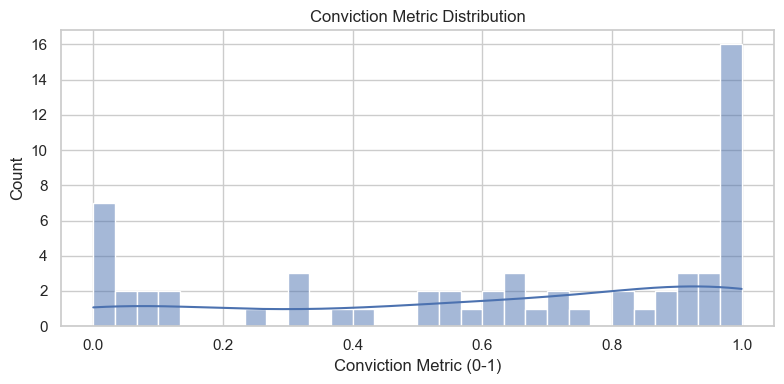

In [47]:
### Conviction metric distribution
plt.figure(figsize=(8,4))
sns.histplot(combined['conviction_metric'].dropna(), kde=True, bins=30, color='C0')
plt.title('Conviction Metric Distribution')
plt.xlabel('Conviction Metric (0-1)')
plt.tight_layout()
plt.savefig(FIG_OUT / 'conviction_distribution.png', dpi=150)
plt.show()

C:\Users\Aalok\AppData\Local\Temp\ipykernel_13228\1150727209.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top15, y='Stock', x='fund_count', palette='viridis')


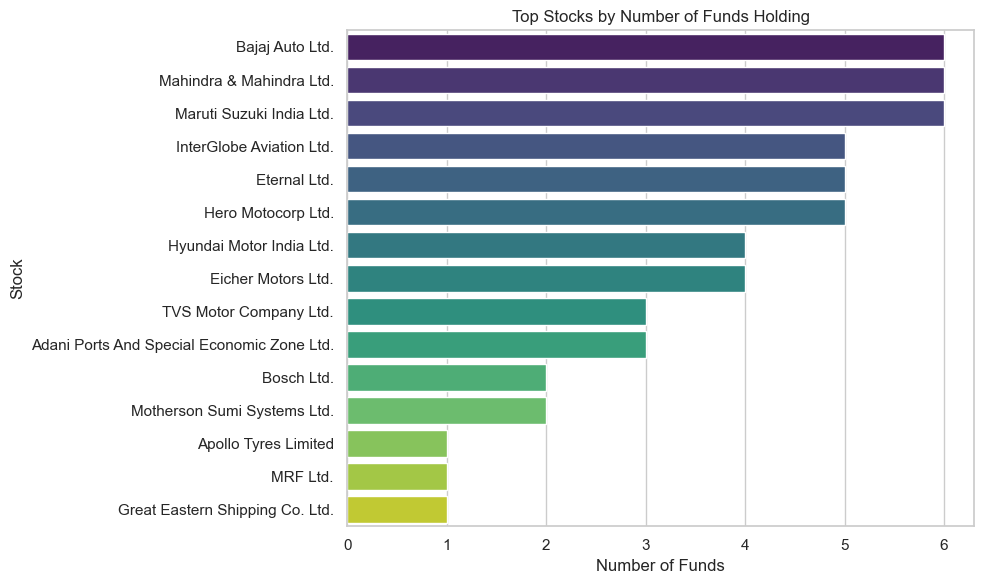

In [48]:
### Top common stocks (by funds holding)
top15 = stock_counts.sort_values('fund_count', ascending=False).head(15)
plt.figure(figsize=(10,6))
sns.barplot(data=top15, y='Stock', x='fund_count', palette='viridis')
plt.title('Top Stocks by Number of Funds Holding')
plt.xlabel('Number of Funds')
plt.ylabel('Stock')
plt.tight_layout()
plt.savefig(FIG_OUT / 'top_stocks_fundcount.png', dpi=150)
plt.show()

C:\Users\Aalok\AppData\Local\Temp\ipykernel_13228\3311204703.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_agg, y='Stock', x='agg_pct_sum', palette='flare')


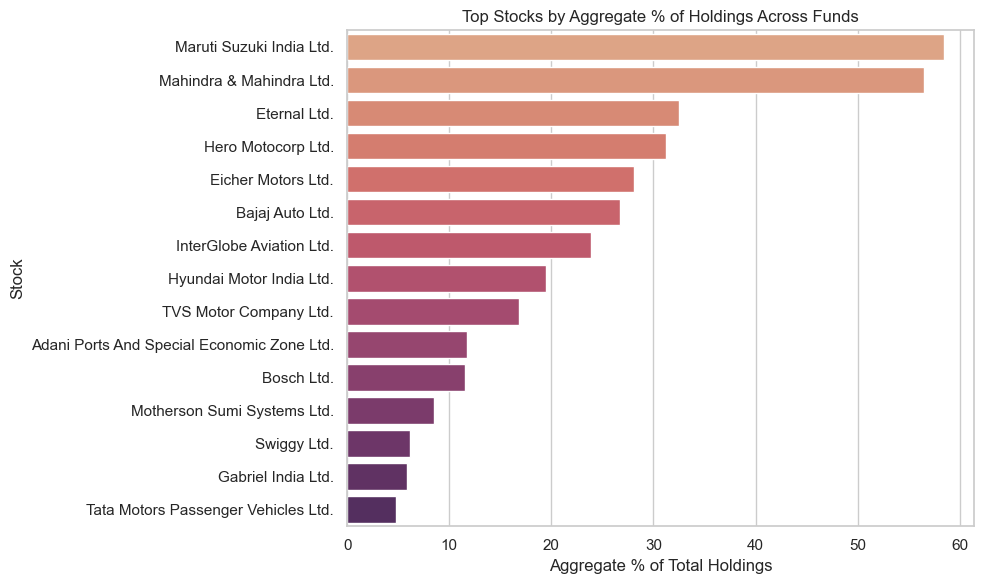

In [49]:
### Aggregate exposure: top stocks by total % across funds


top_agg = agg_pct.head(15)
plt.figure(figsize=(10,6))
sns.barplot(data=top_agg, y='Stock', x='agg_pct_sum', palette='flare')
plt.title('Top Stocks by Aggregate % of Holdings Across Funds')
plt.xlabel('Aggregate % of Total Holdings')
plt.ylabel('Stock')
plt.tight_layout()
plt.savefig(FIG_OUT / 'top_stocks_agg_pct.png', dpi=150)
plt.show()

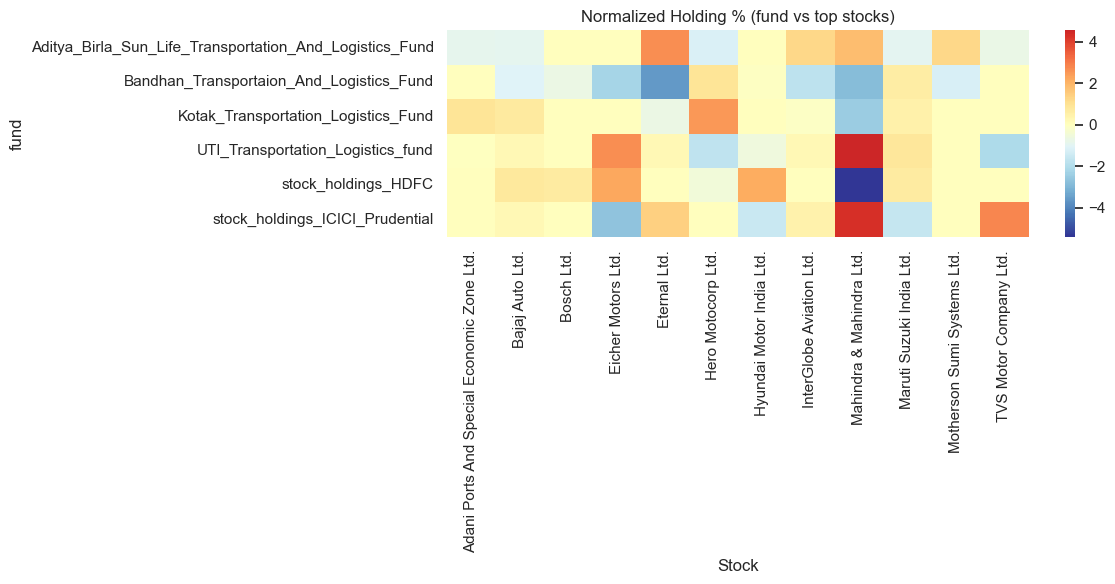

In [50]:

top_stocks = agg_pct.head(12)['Stock'].tolist()
pivot = combined[combined['Stock'].isin(top_stocks)].pivot_table(index='fund', columns='Stock', values='normalized_holding_pct', aggfunc='mean').fillna(0)

plt.figure(figsize=(12,6))
sns.heatmap(pivot, cmap='RdYlBu_r', center=0, annot=False)
plt.title('Normalized Holding % (fund vs top stocks)')
plt.tight_layout()
plt.savefig(FIG_OUT / 'heatmap_normalized_holding.png', dpi=150)
plt.show()

C:\Users\Aalok\AppData\Local\Temp\ipykernel_13228\3148294347.py:10: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=data2, x='1m_change_num', y='1m_change_qty_num', levels=5, color='k', linewidths=1, alpha=0.6)


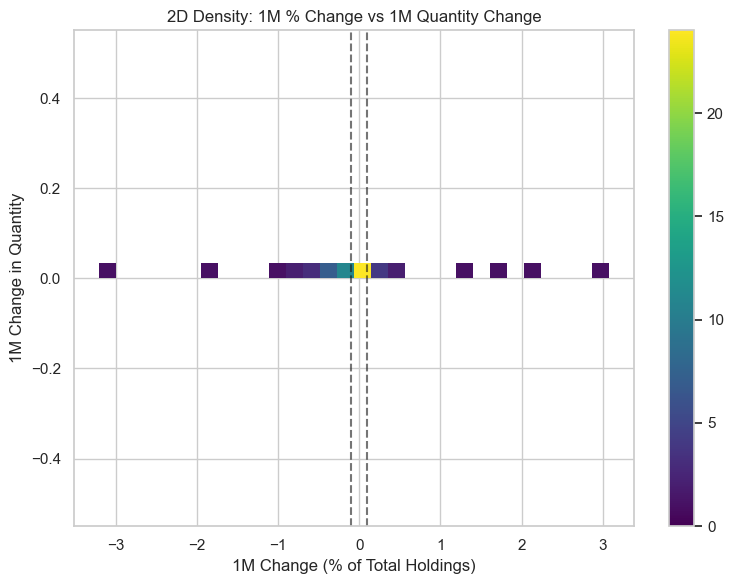

In [51]:
### 2D density: 1M Change vs Quantity change

# Use a 2D histogram + KDE contours to show where observations concentrate
data2 = combined[['1m_change_num','1m_change_qty_num','momentum_flag']].dropna(subset=['1m_change_num','1m_change_qty_num'])
plt.figure(figsize=(8,6))
# 2D histogram
sns.histplot(data=data2, x='1m_change_num', y='1m_change_qty_num', bins=30, pmax=0.9, cmap='viridis', cbar=True)
# overlay KDE contours if available
try:
    sns.kdeplot(data=data2, x='1m_change_num', y='1m_change_qty_num', levels=5, color='k', linewidths=1, alpha=0.6)
except Exception:
    pass

plt.axvline(0.1, color='k', linestyle='--', alpha=0.6)
plt.axvline(-0.1, color='k', linestyle='--', alpha=0.6)
plt.title('2D Density: 1M % Change vs 1M Quantity Change')
plt.xlabel('1M Change (% of Total Holdings)')
plt.ylabel('1M Change in Quantity')
plt.tight_layout()
plt.savefig(FIG_OUT / 'density_1m_pct_vs_qty.png', dpi=150)
plt.show()

### Returns Data — Load & Combine

Purpose: Load all CSV files from the SIP returns folder, detect the column containing periodic returns, standardize percent formatting, add a `fund` column (derived from the filename), and produce `combined_returns` containing `fund`, `return` (raw string), `ret_dec` (decimal), and `cum_return` (fund-level cumulative return).

Expected output: a pandas DataFrame `combined_returns`. Run the following loader cell to see which files were read or skipped and to preview the top rows.

In [52]:
import pandas as pd
import re
from pathlib import Path

# Use SIP Returns Data directory (prefer root folder named exactly 'SIP Returns Data')
candidates = [Path('SIP Returns Data'), Path('SIP_Returns_Data'), Path('SIP_Returns Data')]
if 'BASE' in globals():
    candidates += [BASE.parent / 'SIP Returns Data', BASE.parent / 'SIP_Returns_Data']

SIP_DIR = next((c for c in candidates if c.exists()), None)
if SIP_DIR is None:
    raise FileNotFoundError(f"No SIP Returns Data directory found. Tried: {[str(c) for c in candidates]}")

files_ret = sorted(SIP_DIR.glob('*.csv'))
if not files_ret:
    print('No CSV files found in', SIP_DIR)

rows = []

# robust column detection
date_regex = re.compile(r'date|period|^dt$', re.I)
ret_regex = re.compile(r'return|ret|returns|pct|%|change', re.I)

for fp in files_ret:
    fund = fp.stem
    try:
        df = pd.read_csv(fp)
    except Exception as e:
        print('Skipping', fp.name, 'read error:', e)
        continue
    df.columns = [c.strip() for c in df.columns]
    # detect return column; date is optional and will be ignored later
    ret_col = next((c for c in df.columns if ret_regex.search(c)), None)
    if ret_col is None:
        print('Skipping', fp.name, '— could not detect return column. Columns:', df.columns.tolist())
        continue

    # prepare frame keeping fund, return, ret_dec (no date column)
    tmp = df[[ret_col]].rename(columns={ret_col: 'return'}).copy()
    tmp['fund'] = fund
    tmp['return'] = tmp['return'].astype(str).str.replace('%', '', regex=False).str.replace(',', '', regex=False)
    tmp['ret_dec'] = pd.to_numeric(tmp['return'], errors='coerce') / 100.0
    # keep all rows even if they have no date information
    rows.append(tmp[['fund', 'return', 'ret_dec']])

if rows:
    combined_returns = pd.concat(rows, ignore_index=True)
    # compute cumulative returns per fund in the row order (no date used)
    combined_returns['cum_return'] = (1 + combined_returns['ret_dec'].fillna(0)).groupby(combined_returns['fund']).cumprod() - 1
else:
    combined_returns = pd.DataFrame(columns=['fund', 'return', 'ret_dec', 'cum_return'])

# quick preview
combined_returns

,fund,return,ret_dec,cum_return
0,Aditya_Birla_Sun_Life_Transportation_And_Logis...,14.92,0.1492,0.149200
1,Aditya_Birla_Sun_Life_Transportation_And_Logis...,18.19,0.1819,0.358239
2,Aditya_Birla_Sun_Life_Transportation_And_Logis...,9.4,0.0940,0.485914
3,Bandhan_Transportaion_And_Logistics_Fund_SIP_R...,17.44,0.1744,0.174400
4,Bandhan_Transportaion_And_Logistics_Fund_SIP_R...,21.13,0.2113,0.422551
5,Bandhan_Transportaion_And_Logistics_Fund_SIP_R...,44.23,0.4423,1.051745
6,sip_returns_HDFC,18.64,0.1864,0.186400
7,sip_returns_HDFC,25.8,0.2580,0.492491
8,sip_returns_ICICI_Prudential,15.91,0.1591,0.159100
9,sip_returns_ICICI_Prudential,22.56,0.2256,0.420593


**Returns — Cleaning & Feature Engineering**

This section analyses completeness of `combined_returns` and applies conservative imputation where necessary. The first code cell computes the count and percentage of missing values by column and displays the result as a small table. Run it to see which columns need attention.

In [53]:
# Missing value analysis for combined_returns
import numpy as np
from IPython.display import display
from pathlib import Path

if 'combined_returns' not in globals():
    raise NameError('`combined_returns` not found. Run the SIP loader cell (Returns Data) first.')

missing = combined_returns.isna().sum().rename('missing_count').reset_index().rename(columns={'index':'column'})
missing['missing_pct'] = (missing['missing_count'] / len(combined_returns) * 100).round(3)
display(missing.sort_values('missing_pct', ascending=False))

,column,missing_count,missing_pct
0,fund,0,0.0
1,return,0,0.0
2,ret_dec,0,0.0
3,cum_return,0,0.0


**Imputation details**

We apply a conservative imputation because there is no reliable date index to allow interpolation:
- `ret_dec`: missing values are set to 0.0 and marked with a boolean flag `ret_dec_imputed`.
- `return` (raw): missing strings are filled with an empty string.

After running the cell you will see a small preview of `combined_returns` showing imputed rows (if any).

In [54]:
# Imputation strategy:
# - 'ret_dec': replace missing with 0.0 and flag rows imputed (no date-based interpolation available).
# - 'return' (raw string): fill missing with empty string.

combined_returns['return'] = combined_returns['return'].fillna('')
if 'ret_dec' in combined_returns.columns:
    combined_returns['ret_dec_imputed'] = False
    mask = combined_returns['ret_dec'].isna()
    combined_returns.loc[mask, 'ret_dec'] = 0.0
    combined_returns.loc[mask, 'ret_dec_imputed'] = True

# show a quick preview after imputation
display(combined_returns.head())

,fund,return,ret_dec,cum_return,ret_dec_imputed
0,Aditya_Birla_Sun_Life_Transportation_And_Logis...,14.92,0.1492,0.149200,False
1,Aditya_Birla_Sun_Life_Transportation_And_Logis...,18.19,0.1819,0.358239,False
2,Aditya_Birla_Sun_Life_Transportation_And_Logis...,9.4,0.0940,0.485914,False
3,Bandhan_Transportaion_And_Logistics_Fund_SIP_R...,17.44,0.1744,0.174400,False
4,Bandhan_Transportaion_And_Logistics_Fund_SIP_R...,21.13,0.2113,0.422551,False


**Feature extraction & selection**

This cell computes fund-level summary features from `combined_returns` such as observation count, mean/std/median/min/max of `ret_dec`, and the last observed cumulative return (`last_cum`).

It then performs simple feature selection: removing numeric columns with zero variance and dropping one of any pair of features with absolute correlation > 0.95. The printed output shows which columns were removed and a preview of the selected feature table.

In [55]:
# Feature extraction: compute fund-level aggregate features
fund_features = combined_returns.groupby('fund').agg(
    n_obs=('ret_dec','size'),
    mean_ret=('ret_dec','mean'),
    std_ret=('ret_dec','std'),
    median_ret=('ret_dec','median'),
    min_ret=('ret_dec','min'),
    max_ret=('ret_dec','max'),
    last_cum=('cum_return','last')
).reset_index()

# Simple feature selection: drop zero-variance numeric columns and highly correlated pairs (>0.95)
num_cols = fund_features.select_dtypes(include=[np.number]).columns.tolist()
vars_ = fund_features[num_cols].var(numeric_only=True)
drop_zero_var = vars_[vars_ == 0].index.tolist()
selected = fund_features.drop(columns=drop_zero_var) if drop_zero_var else fund_features.copy()

# Drop one of any pair with absolute correlation > 0.95
corr = selected.select_dtypes(include=[np.number]).corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [c for c in upper.columns if any(upper[c] > 0.95)]
selected = selected.drop(columns=to_drop) if to_drop else selected

print('Dropped zero-variance columns:', drop_zero_var)
print('Dropped highly correlated columns:', to_drop)
display(selected.head())

Dropped zero-variance columns: []
Dropped highly correlated columns: ['std_ret', 'median_ret', 'max_ret', 'last_cum']


,fund,n_obs,mean_ret,min_ret
0,Aditya_Birla_Sun_Life_Transportation_And_Logis...,3,0.14170,0.0940
1,Bandhan_Transportaion_And_Logistics_Fund_SIP_R...,3,0.27600,0.1744
2,UTI_Transportation_Logistics_fund_sip,5,0.65256,0.1634
3,sip_returns_HDFC,2,0.22220,0.1864
4,sip_returns_ICICI_Prudential,3,0.29020,0.1591


**Returns — Visualizations**

This section creates visual summaries for the SIP returns and fund-level features. Plots are saved to `outputs/figs`. Run these cells to generate the figures and a short printed set of findings computed from the data.

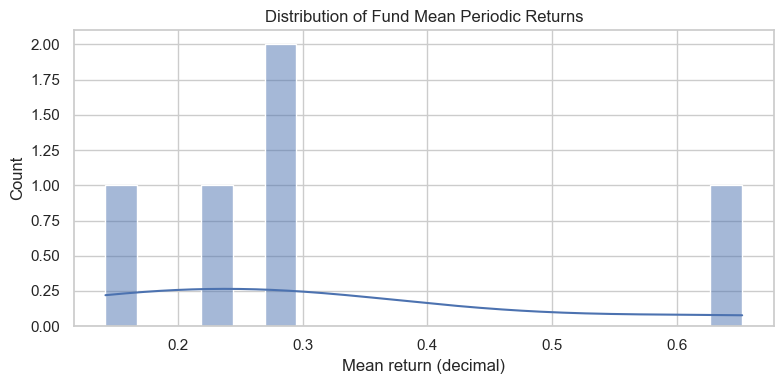

C:\Users\Aalok\AppData\Local\Temp\ipykernel_13228\3639771061.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='n_obs', y='fund', data=top_n, palette='magma')


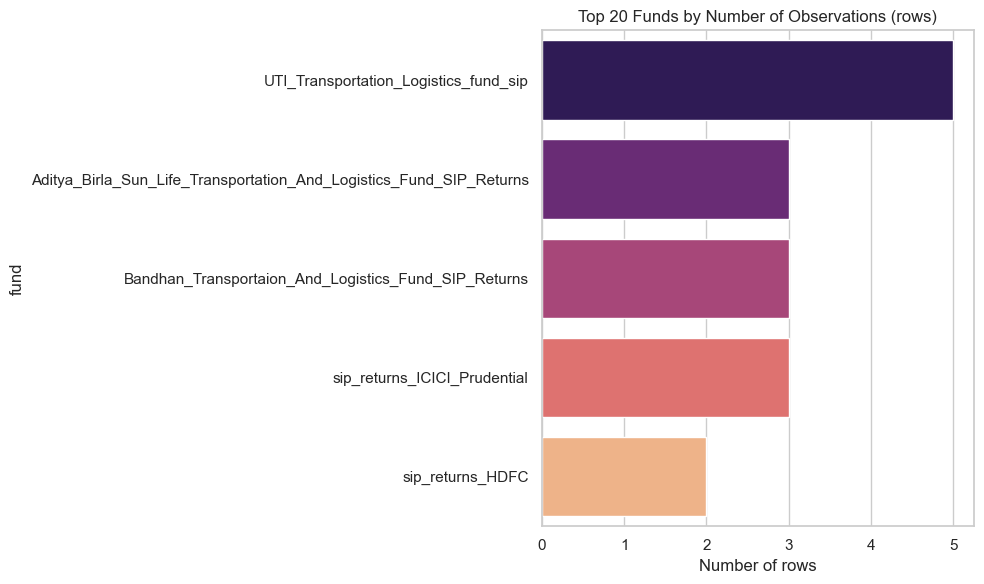

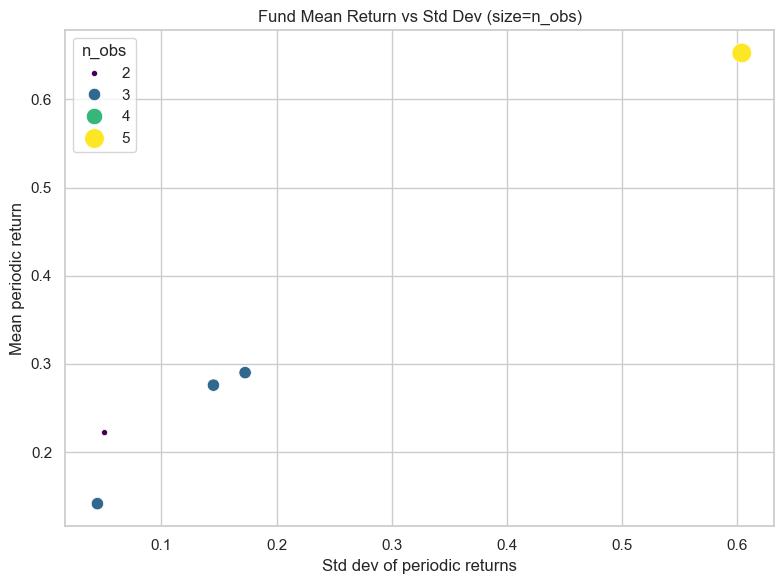

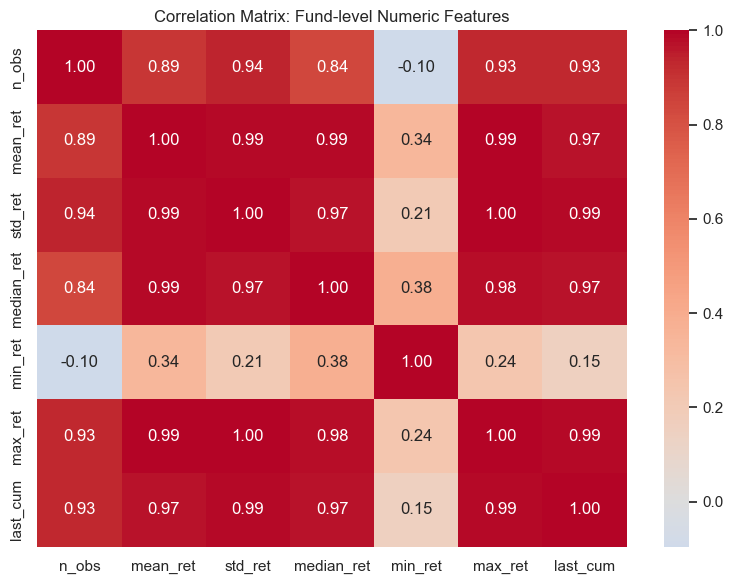

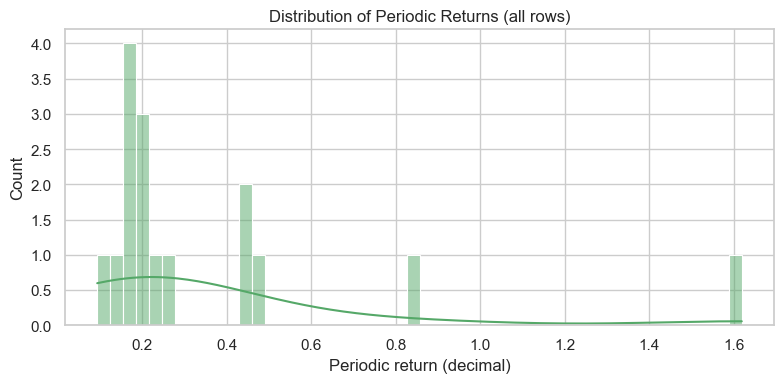

C:\Users\Aalok\AppData\Local\Temp\ipykernel_13228\3639771061.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='last_cum', y='fund', data=top5, palette='crest')


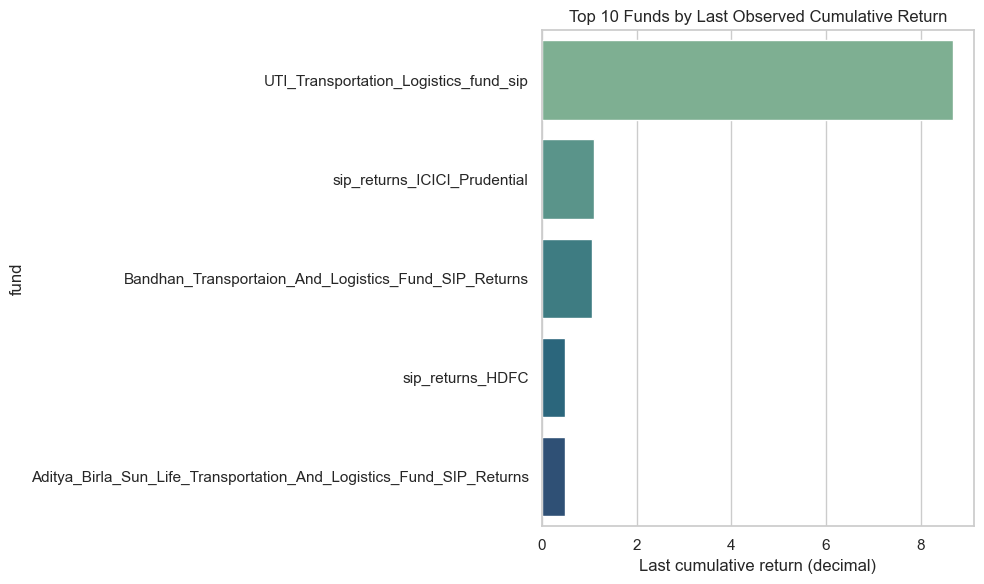

C:\Users\Aalok\AppData\Local\Temp\ipykernel_13228\3639771061.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='last_cum', y='fund', data=bot5, palette='rocket')


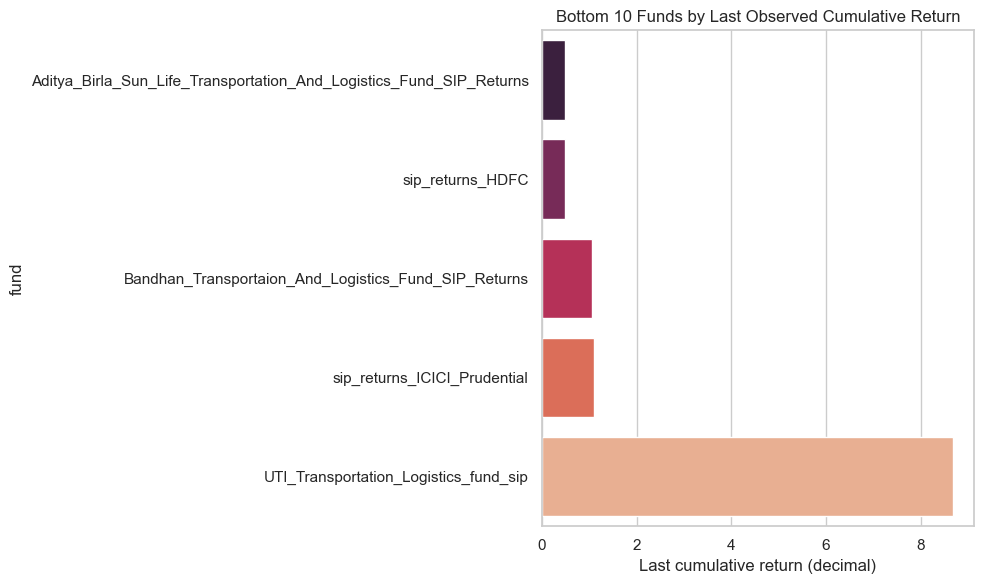

In [56]:
# Visualizations: distributions, barplots, scatter, heatmap
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
sns.set(style='whitegrid')
FIG_OUT = Path('outputs') / 'figs'
FIG_OUT.mkdir(parents=True, exist_ok=True)

# 1) Histogram of fund mean returns
plt.figure(figsize=(8,4))
# pass the series as an array via the x= parameter to satisfy strict type-checkers
sns.histplot(x=fund_features['mean_ret'].dropna().to_numpy(), kde=True, bins=20, color='C0')
plt.title('Distribution of Fund Mean Periodic Returns')
plt.xlabel('Mean return (decimal)')
plt.tight_layout()
plt.savefig(FIG_OUT / 'fund_mean_ret_hist.png', dpi=150)
plt.show()

# 2) Top funds by number of observations (n_obs) - horizontal bar (top 20)
top_n = fund_features.sort_values('n_obs', ascending=False).head(20)
plt.figure(figsize=(10,6))
sns.barplot(x='n_obs', y='fund', data=top_n, palette='magma')
plt.title('Top 20 Funds by Number of Observations (rows)')
plt.xlabel('Number of rows')
plt.tight_layout()
plt.savefig(FIG_OUT / 'fund_n_obs_top20.png', dpi=150)
plt.show()

# 3) Scatter: mean vs std of periodic returns per fund
plt.figure(figsize=(8,6))
sns.scatterplot(data=fund_features, x='std_ret', y='mean_ret', hue='n_obs', palette='viridis', size='n_obs', sizes=(20,200), legend='brief')
plt.title('Fund Mean Return vs Std Dev (size=n_obs)')
plt.xlabel('Std dev of periodic returns')
plt.ylabel('Mean periodic return')
plt.tight_layout()
plt.savefig(FIG_OUT / 'fund_mean_vs_std.png', dpi=150)
plt.show()

# 4) Heatmap of correlations between numeric fund features
# ensure we keep 'fund' as the index before selecting numeric columns
numf = fund_features.set_index('fund').select_dtypes(include=[float, int])
corr = numf.corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Correlation Matrix: Fund-level Numeric Features')
plt.tight_layout()
plt.savefig(FIG_OUT / 'fund_features_corr.png', dpi=150)
plt.show()

# 5) Distribution of individual periodic returns across all rows
plt.figure(figsize=(8,4))
# use x= with numpy array to avoid Series type errors from static analyzers
sns.histplot(x=combined_returns['ret_dec'].dropna().to_numpy(), bins=50, kde=True, color='C2')
plt.title('Distribution of Periodic Returns (all rows)')
plt.xlabel('Periodic return (decimal)')
plt.tight_layout()
plt.savefig(FIG_OUT / 'ret_dec_distribution.png', dpi=150)
plt.show()

# 6) Top/Bottom funds by last cumulative return (barplot)
top5 = fund_features.sort_values('last_cum', ascending=False).head(10)
bot5 = fund_features.sort_values('last_cum', ascending=True).head(10)
plt.figure(figsize=(10,6))
sns.barplot(x='last_cum', y='fund', data=top5, palette='crest')
plt.title('Top 10 Funds by Last Observed Cumulative Return')
plt.xlabel('Last cumulative return (decimal)')
plt.tight_layout()
plt.savefig(FIG_OUT / 'top10_last_cum.png', dpi=150)
plt.show()

plt.figure(figsize=(10,6))
sns.barplot(x='last_cum', y='fund', data=bot5, palette='rocket')
plt.title('Bottom 10 Funds by Last Observed Cumulative Return')
plt.xlabel('Last cumulative return (decimal)')
plt.tight_layout()
plt.savefig(FIG_OUT / 'bot10_last_cum.png', dpi=150)
plt.show()

**Visualization — Findings (automatically computed)**

The next cell computes concise numeric findings from the plotted data: overall averages, and the top/bottom funds by key metrics. Run it to see the results for your dataset.

In [57]:
# Compute and print concise findings (summary statistics)
def pct(x):
    try:
        return f"{x:.2%}"
    except Exception:
        return str(x)

print('Number of funds:', len(fund_features))
print('Average of fund mean periodic returns:', pct(fund_features['mean_ret'].mean()))
print('Median of fund mean periodic returns:', pct(fund_features['mean_ret'].median()))
print('Average fund std dev:', fund_features['std_ret'].mean())

print('\nTop 5 funds by mean periodic return:')
print(fund_features.sort_values('mean_ret', ascending=False)[['fund','mean_ret']].head(5).to_string(index=False))

print('\nTop 5 funds by last cumulative return:')
print(fund_features.sort_values('last_cum', ascending=False)[['fund','last_cum']].head(5).to_string(index=False))

print('\nBottom 5 funds by last cumulative return:')
print(fund_features.sort_values('last_cum', ascending=True)[['fund','last_cum']].head(5).to_string(index=False))

print('\nTop correlations (abs) among numeric fund features:')
numf = fund_features.set_index('fund').select_dtypes(include=[float, int])
corr = numf.corr().abs()
pairs = []
for i, c in enumerate(corr.columns):
    for j in range(i+1, len(corr.columns)):
        v = corr.iloc[i, j]
        pairs.append((corr.columns[i], corr.columns[j], v))
pairs = sorted(pairs, key=lambda x: x[2], reverse=True)[:10]
for a,b,v in pairs:
    print(f'{a} <-> {b}: {v:.2f}')
def pct(x):
    try:
        return f"{x:.2%}"
    except Exception:
        return str(x)

print('Number of funds:', len(fund_features))
print('Average of fund mean periodic returns:', pct(fund_features['mean_ret'].mean()))
print('Median of fund mean periodic returns:', pct(fund_features['mean_ret'].median()))
print('Average fund std dev:', fund_features['std_ret'].mean())

print('\nTop 5 funds by mean periodic return:')
print(fund_features.sort_values('mean_ret', ascending=False)[['fund','mean_ret']].head(5).to_string(index=False))

print('\nTop 5 funds by last cumulative return:')
print(fund_features.sort_values('last_cum', ascending=False)[['fund','last_cum']].head(5).to_string(index=False))

print('\nBottom 5 funds by last cumulative return:')
print(fund_features.sort_values('last_cum', ascending=True)[['fund','last_cum']].head(5).to_string(index=False))

print('\nTop correlations (abs) among numeric fund features:')
numf = fund_features.set_index('fund').select_dtypes(include=[float, int])
corr = numf.corr().abs()
pairs = []
for i, c in enumerate(corr.columns):
    for j in range(i+1, len(corr.columns)):
        v = corr.iloc[i, j]
        pairs.append((corr.columns[i], corr.columns[j], v))
pairs = sorted(pairs, key=lambda x: x[2], reverse=True)[:10]
for a,b,v in pairs:
    print(f'{a} <-> {b}: {v:.2f}')

Number of funds: 5
Average of fund mean periodic returns: 31.65%
Median of fund mean periodic returns: 27.60%
Average fund std dev: 0.20340519221052186

Top 5 funds by mean periodic return:
                                                               fund  mean_ret
                              UTI_Transportation_Logistics_fund_sip   0.65256
                                       sip_returns_ICICI_Prudential   0.29020
               Bandhan_Transportaion_And_Logistics_Fund_SIP_Returns   0.27600
                                                   sip_returns_HDFC   0.22220
Aditya_Birla_Sun_Life_Transportation_And_Logistics_Fund_SIP_Returns   0.14170

Top 5 funds by last cumulative return:
                                                               fund  last_cum
                              UTI_Transportation_Logistics_fund_sip  8.690220
                                       sip_returns_ICICI_Prudential  1.110859
               Bandhan_Transportaion_And_Logistics_Fund_SIP_Returns 

**Machine Learning — Modeling**

This section builds simple ML models on the fund-level features to demonstrate predictive workflows. It includes:
- Regression models predicting `last_cum` (last observed cumulative return).
- A classification task that labels funds in the top quartile of `last_cum` as `1` (target for classification).

Each code cell is accompanied by explanatory notes and evaluation metrics. Models and artifacts are saved to `outputs/models/` for later use.

In [59]:
# Machine Learning imports and dataset preparation
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from pathlib import Path

# sklearn imports
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import joblib

OUT = Path('outputs')
MODELS_OUT = OUT / 'models'
MODELS_OUT.mkdir(parents=True, exist_ok=True)

# Robust feature-table selection: prefer 'selected' if it contains 'last_cum', otherwise fall back to 'fund_features'
df_features = None
if 'selected' in globals() and isinstance(selected, pd.DataFrame) and 'last_cum' in selected.columns:
    df_features = selected.copy()
elif 'fund_features' in globals() and isinstance(fund_features, pd.DataFrame) and 'last_cum' in fund_features.columns:
    df_features = fund_features.copy()
elif 'selected' in globals() and isinstance(selected, pd.DataFrame):
    # selected exists but may have dropped last_cum; try to merge last_cum from fund_features if available
    df_features = selected.copy()
    if 'fund_features' in globals() and isinstance(fund_features, pd.DataFrame) and 'last_cum' in fund_features.columns:
        if 'fund' in df_features.columns:
            df_features = df_features.merge(fund_features[['fund', 'last_cum']], on='fund', how='left')
        else:
            # last resort: try to align by index (only if sizes match)
            try:
                ff = fund_features.reset_index().rename(columns={fund_features.index.name or 'index':'ff_index'})
            except Exception:
                ff = None

if df_features is None:
    raise KeyError("No features table with 'last_cum' found. Run the feature extraction cell to create 'fund_features' (and ensure 'last_cum' is present).")

# ensure 'fund' is an index (many downstream operations assume this)
if 'fund' in df_features.columns:
    df_features = df_features.set_index('fund')

# drop any non-numeric leftover columns
X_all = df_features.select_dtypes(include=[np.number]).copy()

# require target 'last_cum' for regression/classification
if 'last_cum' not in X_all.columns:
    raise KeyError("'last_cum' target not found in numeric features after preparation. Check 'fund_features' and 'selected' tables.")

# Regression target
y_reg = X_all['last_cum'].fillna(0.0)
X_reg = X_all.drop(columns=['last_cum']).fillna(0.0)

# Classification target: top-quartile by last_cum
th = y_reg.quantile(0.75)
y_clf = (y_reg >= th).astype(int)
X_clf = X_reg.copy()

print('Prepared ML datasets:')
print('- features shape (reg/clf):', X_reg.shape, X_clf.shape)
print('- regression target mean:', y_reg.mean())
print('- classification positive rate (top quartile):', y_clf.mean())

Prepared ML datasets:
- features shape (reg/clf): (5, 6) (5, 6)
- regression target mean: 2.366245781363543
- classification positive rate (top quartile): 0.4


**Regression models**

We train several regression algorithms (LinearRegression, RidgeCV, LassoCV, RandomForestRegressor) to predict `last_cum`. We evaluate using MSE and R^2 on a held-out test set and with cross-validation.

In [62]:
# Train / evaluate regression models
from sklearn.pipeline import make_pipeline

X_train, X_test, y_train, y_test = train_test_split(X_reg, y_reg, test_size=0.25, random_state=42)
scaler = StandardScaler()

# Determine a safe number of CV folds based on available samples
n_samples = len(X_reg)
if n_samples < 2:
    raise ValueError(f'Not enough samples for training (n_samples={n_samples}). Need at least 2.')
# use up to 5 folds but never more than n_samples; require at least 2 folds for CV
cv_folds = min(5, n_samples) if n_samples >= 2 else None

models_reg = {
    'Linear': LinearRegression(),
    'RidgeCV': RidgeCV(alphas=(0.1, 1.0, 10.0)),
    'LassoCV': LassoCV(cv=cv_folds) if (cv_folds is not None and cv_folds >= 2) else LassoCV(cv=2),
    'RandomForest': RandomForestRegressor(n_estimators=200, random_state=42)
}
results_reg = {}
for name, m in models_reg.items():
    pipe = make_pipeline(scaler, m)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    # compute cross-validated R2 only when we have at least 2 samples
    if n_samples >= 2:
        try:
            cv_r2 = cross_val_score(pipe, X_reg, y_reg, cv=cv_folds, scoring='r2').mean()
        except Exception:
            cv_r2 = float('nan')
    else:
        cv_r2 = float('nan')
    results_reg[name] = {'mse': mse, 'r2': r2, 'cv_r2': cv_r2}
    # save model
    joblib.dump(pipe, MODELS_OUT / f'model_reg_{name}.joblib')
    print(f'Reg {name}: MSE={mse:.6f}, R2={r2:.4f}, CV_R2={cv_r2 if not (cv_r2!=cv_r2) else 'nan'}')

results_reg

Reg Linear: MSE=0.823680, R2=-941.8343, CV_R2=nan
Reg RidgeCV: MSE=0.846649, R2=-968.1255, CV_R2=nan


ValueError: Cannot have number of splits n_splits=5 greater than the number of samples: n_samples=3.

**Classification models**

We create a binary target indicating whether a fund is in the top quartile of `last_cum`. We train LogisticRegression, RandomForestClassifier, and GradientBoostingClassifier. Evaluation uses accuracy, precision, recall, F1 and ROC-AUC.

In [61]:
# Train / evaluate classification models
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_clf, y_clf, test_size=0.25, random_state=42, stratify=y_clf)
models_clf = {
    'Logistic': LogisticRegression(max_iter=1000),
    'RF': RandomForestClassifier(n_estimators=200, random_state=42),
    'GB': GradientBoostingClassifier(n_estimators=200, random_state=42)
}
results_clf = {}
for name, m in models_clf.items():
    pipe = make_pipeline(scaler, m)
    pipe.fit(X_train_c, y_train_c)
    y_pred = pipe.predict(X_test_c)
    y_prob = pipe.predict_proba(X_test_c)[:,1] if hasattr(pipe[-1], 'predict_proba') else None
    acc = accuracy_score(y_test_c, y_pred)
    prec = precision_score(y_test_c, y_pred, zero_division=0)
    rec = recall_score(y_test_c, y_pred, zero_division=0)
    f1 = f1_score(y_test_c, y_pred, zero_division=0)
    roc = roc_auc_score(y_test_c, y_prob) if y_prob is not None else np.nan
    results_clf[name] = {'acc': acc, 'prec': prec, 'rec': rec, 'f1': f1, 'roc': roc}
    joblib.dump(pipe, MODELS_OUT / f'model_clf_{name}.joblib')
    print(f'Clf {name}: ACC={acc:.3f}, PREC={prec:.3f}, REC={rec:.3f}, F1={f1:.3f}, ROC-AUC={roc:.3f}')

results_clf

Clf Logistic: ACC=1.000, PREC=1.000, REC=1.000, F1=1.000, ROC-AUC=1.000
Clf RF: ACC=1.000, PREC=1.000, REC=1.000, F1=1.000, ROC-AUC=1.000
Clf GB: ACC=1.000, PREC=1.000, REC=1.000, F1=1.000, ROC-AUC=1.000
Clf RF: ACC=1.000, PREC=1.000, REC=1.000, F1=1.000, ROC-AUC=1.000
Clf GB: ACC=1.000, PREC=1.000, REC=1.000, F1=1.000, ROC-AUC=1.000


{'Logistic': {'acc': 1.0, 'prec': 1.0, 'rec': 1.0, 'f1': 1.0, 'roc': 1.0},
 'RF': {'acc': 1.0, 'prec': 1.0, 'rec': 1.0, 'f1': 1.0, 'roc': 1.0},
 'GB': {'acc': 1.0, 'prec': 1.0, 'rec': 1.0, 'f1': 1.0, 'roc': 1.0}}

**Next steps & notes**

- These models are a demonstration: the dataset (number of funds) is typically small — use caution interpreting results.
- To improve: add more fund-level features (rolling statistics on returns when dates available), perform hyperparameter tuning, and apply nested CV.
- Trained models are saved to `outputs/models/`. You can reload with `joblib.load(...)` for downstream analysis or ensemble building.